In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

print(f"Available datasets: {dataset_names}")


Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

/home/reshawn/miniconda3/envs/clfr/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
dataset = get_dataset("m4_hourly")

In [8]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7650a1f59650>, iterable=JsonLinesFile(path=PosixPath('/home/reshawn/.gluonts/datasets/m4_hourly/train/data.json.gz'), start=0, n=None, line_starts=[0, 4983, 10666, 16222, 21905, 27588, -32265, -25882, -19499, -13116, -8133, -1748, 4093, 9078, 14063, 20381, 25867, 32252, -26899, -21214, -15509, -9124, -4139, 846, 5879, 11564, 17949, 23634, 29319, -30532, -23789, -17145, -10595, -4910, 1475, 7160, 13545, 19230, 24915, 31656, -28195, -22510, -16825, -11140, -5706, 679, 5728, 12113, 17798, 24183, 30568, -29983, -24298, -18613, -13628, -8643, -2258, 4827, 10512, 16028, 21181, 26866, 31830, -28021, -22362, -16144, -9763, -3378, 3007, 8258, 14643, 20481, 25466, 30511, -30040, -23757, -18772, -13785, -7400, -1015, 4670, 10355, 16739, 22054, 27039, 32152, -28414, -23429, -18278, -12597, -6215, -540, 5145, 10830, 17444, 23935, 29620, -29531, -23846, -17461, -12166, -6479, -819, 5911, 11589, 17276, 22963, 28650, -31898, -25511, -19124, -

In [ ]:
entry = next(iter(dataset.test))

# diff to get the changes across values
# get the range of thoses changes
# use that set windows for categorized targets


In [46]:
import pandas as pd
df = pd.DataFrame(entry['target'])
df.diff().dropna().describe()

,0
count,699.000000
mean,0.113019
std,40.881477
min,-114.000000
25%,-30.500000
50%,-4.000000
75%,31.500000
max,101.000000


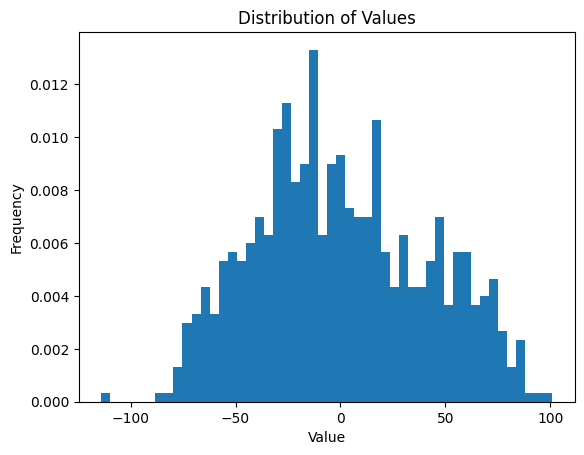

In [22]:
import matplotlib.pyplot as plt

# assume 'series' is a pandas Series object
plt.hist(df[[0]].diff().dropna(), bins=50, density=True)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [69]:
changes.describe()

,0
count,699.000000
mean,0.113019
std,40.881477
min,-114.000000
25%,-30.500000
50%,-4.000000
75%,31.500000
max,101.000000


In [71]:
import pandas as pd
import numpy as np

def adjust_split_point(series, threshold=0.05, max_iterations=1000):
    split_point = np.median(series)
    increment = 0.01  # Initial increment
    iterations = 0

    while iterations < max_iterations:
        binary_series = (series > split_point).astype(int)
        balance = binary_series.mean()[0]

        # Check if balance is within the threshold
        if abs(balance - 0.5) <= threshold:
            break

        # Adjust increment based on how far off the balance is
        distance_from_balance = abs(balance - 0.5)
        increment = max(0.001, increment * (1 + distance_from_balance))  # Scale increment

        # Adjust split point based on balance
        if balance < 0.5:
            split_point -= increment
        else:
            split_point += increment

        iterations += 1

    return split_point



df = pd.DataFrame(entry['target'])
series = df[[0]].copy()
changes = series.diff().dropna()

split_point = adjust_split_point(changes)
binary_series = (changes > split_point).astype(int)

df = df.iloc[:-1].copy() # reflect diff drop of row 1 on original df
df['label'] = binary_series.values
df.rename(columns={0: 'values'}, inplace=True)

In [67]:
# Define window sizes for rolling calculations
window_sizes = [2, 3, 4, 5]

# Calculate rolling window features for different window sizes
for window_size in window_sizes:
    df[f'rolling_mean_{window_size}'] = df['values'].rolling(window=window_size).mean()
    df[f'rolling_sum_{window_size}'] = df['values'].rolling(window=window_size).sum()
    df[f'rolling_min_{window_size}'] = df['values'].rolling(window=window_size).min()
    df[f'rolling_max_{window_size}'] = df['values'].rolling(window=window_size).max()
    df[f'rolling_std_{window_size}'] = df['values'].rolling(window=window_size).std()

# Calculate additional features
df['lag_1'] = df['values'].shift(1)  # Previous value
df['lag_2'] = df['values'].shift(2)  # Value two steps back
df['lag_3'] = df['values'].shift(3)  # Value three steps back
df['lag_4'] = df['values'].shift(4)  # Value four steps back
df['difference'] = df['values'].diff()  # Difference from the previous value
df['percentage_change'] = df['values'].pct_change()  # Percentage change from the previous value
df['cumulative_sum'] = df['values'].cumsum()  # Cumulative sum
df['cumulative_mean'] = df['values'].expanding().mean()  # Cumulative mean
df['cumulative_max'] = df['values'].cummax()  # Cumulative maximum
df['cumulative_min'] = df['values'].cummin()  # Cumulative minimum
df.dropna(inplace=True)

# Display the resulting DataFrame
print(df)


     values  label  rolling_mean_2  rolling_sum_2  rolling_min_2  \
4     511.0      0           535.0         1070.0          511.0   
5     443.0      0           477.0          954.0          443.0   
6     422.0      0           432.5          865.0          422.0   
7     395.0      0           408.5          817.0          395.0   
8     382.0      0           388.5          777.0          382.0   
..      ...    ...             ...            ...            ...   
694   820.0      0           833.5         1667.0          820.0   
695   790.0      0           805.0         1610.0          790.0   
696   784.0      0           787.0         1574.0          784.0   
697   752.0      0           768.0         1536.0          752.0   
698   739.0      0           745.5         1491.0          739.0   

     rolling_max_2  rolling_std_2  rolling_mean_3  rolling_sum_3  \
4            559.0      33.941125      552.000000         1656.0   
5            511.0      48.083261      504.3333

Goal: To test the method on a wider variety of datasets outside of the described and intended use-case using simple tasks

Towards that variety, monash repository for a breadth of time-series datasets that are consistently formatted and available. 
For a simple task, the datasets are tailored into a binary classification problem per time-series. It is done in a way that ensures a balanced split of classes where possible and windowed rolling, cumulative, and comparative features are derived to support the values in the application of a traditional model.
The simple task formatting may not reflect the difficulty of the datasets' use-cases in practice, but allows for a scalable exploration and comparison at this stage.
Applied to more datasets, it can possibly allow for establishing a clearer definition of the attributes required in a dataset for the method to be applicable.

TODO:
- connect single instance done above to framework and eval
- loop and average to the rest in dataset, wrapping it
- debug and run on whole dataset
- repeat, cant rem how scalable eval is, number of repeats also depends on runtime for the big ones on this laptop
